## Learning from Isochrones: A machine learning approach to estimating stellar properties

### Part 2 - Finding the optimal architecture using the ReLU activation function

##### Luco Buise (s1055446)

---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as ip
import random as ran

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [2]:
# create training data

isochrones = ["FeH05", "FeH0", "FeH-05", "FeH-10", "FeH-15", "FeH-20", "FeH-25"]

isochrone_values = [0.5, 0, -0.5, -1, -1.5, -20, -2.5]

Y = np.array([])
X = np.array([])

for i, iso in enumerate(isochrones):

    loga, mag_B, mag_V = np.loadtxt('isochrones/small_data/isoc_' + iso + '.cmd', usecols=(1, 10, 11), unpack=True)
    loga = np.around(loga, decimals=2) 
    
    # find the highest and lowest age in this isochrone
    min_age = min(loga)
    max_age = max(loga)
    steps = ((max_age - min_age) / 0.1) + 1
    
    # create the ages
    ages = np.linspace(min_age, max_age, int(steps))
    ages = np.around(ages, decimals=2)
        
    # set the y-values, first the age, then the metallicity
    y = np.array([(age, isochrone_values[i]) for age in ages])
        
    if len(Y) == 0:
        Y = y
    else:
        Y = np.append(Y, y, axis = 0)
    
    for age in ages:
        w = np.where(age == loga)
        
        r = sorted(ran.sample(range(0, len(mag_B[w])), 100))
            
        bv = (mag_B[w] - mag_V[w])[r]
        v = mag_V[w][r]

        x = np.array([np.append(bv, v)])

        if len(X) == 0:
            X = x
        else:
            X = np.append(X, x, axis = 0)

X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).float()
print(X_train.shape, y_train.shape)

torch.Size([308, 200]) torch.Size([308, 2])


In [3]:
# load the regressed testing data from files (see the Creating_Test_Data.ipynb notebook for more information)

X_OC = np.load('openClusters/oc_xdata.npy')
Y_OC = np.load('openClusters/oc_ydata.npy')

X_GC = np.load('globClusters/gc_xdata.npy')
Y_GC = np.load('globClusters/gc_ydata.npy')

X_OC = torch.from_numpy(X_OC).float()
Y_OC = torch.from_numpy(Y_OC).float()

X_GC = torch.from_numpy(X_GC).float()
Y_GC = torch.from_numpy(Y_GC).float()

In [4]:
# transform the test data of X_OC and X_GC by adding their distance modulus to the V values

# transform distances in kpc to distance modulus
def kpc_to_mod(kpc):
    return 5 * np.log10(10 / (kpc * 1000))

oc_distances = np.loadtxt("openClusters/Ages_and_properties.txt", usecols = (3), unpack=True)
gc_distances = np.loadtxt("globClusters/Distances.txt", usecols = (1), unpack=True)

gc_distances = kpc_to_mod(gc_distances) * -1

for i, d in enumerate(oc_distances):
    X_OC[i][100:] = X_OC[i][100:] - d

for i, d in enumerate(gc_distances):
    X_GC[i][100:] = X_GC[i][100:] - d


In [5]:
# create helper functions to test the network

# calculate the confidence interval of a given model and input data over n predictions
def conf_int(model, X, n = 1000):
    predicted = np.array([model(X).data.numpy() for k in range(n)])
    pred_age = predicted[:,:, 0]
    pred_z = predicted[:,:, 1]
    
    age_mean = np.mean(pred_age, axis=0)
    z_mean = np.mean(pred_z, axis = 0)
    age_std = np.std(pred_age, axis=0)
    z_std = np.std(pred_z, axis = 0)
    
    age_ci_lb = age_mean - 3 * age_std
    age_ci_ub = age_mean + 3 * age_std
    age_ci = np.array([[lb,ub] for lb,ub in zip(age_ci_lb,age_ci_ub)])

    z_ci_lb = z_mean - 3 * z_std
    z_ci_ub = z_mean + 3 * z_std
    z_ci = np.array([[lb,ub] for lb,ub in zip(z_ci_lb,z_ci_ub)])
    
    return age_ci, z_ci

# calculate the average width of multiple confidence intervals
def avg_ci_width(conf_int):
    widths = conf_int[:, 1] - conf_int[:, 0]
    return widths.mean()

# calculate the average accuracy, using the 99.7 confidence interval (i.e. 3 * std)
def avg_acc(Y, age_ci, z_ci):
    correct_age = 0
    correct_z = 0
    
    for i, y in enumerate(Y):
        
        if float(y[0]) >= float(age_ci[i, 0]) and float(y[0]) <= float(age_ci[i, 1]):
            correct_age += 1
        if float(y[1]) >= float(z_ci[i, 0]) and float(y[1]) <= float(z_ci[i, 1]):
            correct_z += 1
    
    return 100 * float(correct_age) / len(Y), 100 * float(correct_z) / len(Y)

# calculate the average MSE-loss of a given model and data over n predictions
def avg_mse(model, X, Y, n = 1000):
    tot_mse_age = 0
    tot_mse_z = 0
    
    # get average mse
    for i in range(n):
        predicted = model(X).data
        tot_mse_age += ((Y[:,0] - predicted[:,0])**2).mean()
        tot_mse_z += ((Y[:,1] - predicted[:,1])**2).mean()
        
    return tot_mse_age / n, tot_mse_z / n

In [6]:
# create and test regression model

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1

nr_hidden = np.linspace(10,500,50)

acc_age_train = np.array([])
acc_z_train = np.array([])
ci_age_train = np.array([])
ci_z_train = np.array([])
mse_age_train = np.array([])
mse_z_train = np.array([])

acc_age_oc = np.array([])
acc_z_oc = np.array([])
ci_age_oc = np.array([])
ci_z_oc = np.array([])
mse_age_oc = np.array([])
mse_z_oc = np.array([])

acc_age_gc = np.array([])
acc_z_gc = np.array([])
ci_age_gc = np.array([])
ci_z_gc = np.array([])
mse_age_gc = np.array([])
mse_z_gc = np.array([])

for i, n in enumerate(nr_hidden):
    
    # define model
    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=int(n)),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=int(n), out_features=2),
    )

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # start training
    for step in range(3000):
        pre = model(X_train)
        mse = mse_loss(pre, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    # keep track of performance of training set, open clusters, and globular clusters
    age_ci, z_ci = conf_int(model, X_train)
        
    acc_age, acc_z = avg_acc(y_train, age_ci, z_ci)
    acc_age_train = np.append(acc_age_train, [acc_age])
    acc_z_train = np.append(acc_z_train, acc_z)
    
    ci_age_train = np.append(ci_age_train, avg_ci_width(age_ci))
    ci_z_train = np.append(ci_z_train, avg_ci_width(z_ci))
    
    mse_age, mse_z = avg_mse(model, X_train, y_train)
    mse_age_train = np.append(mse_age_train, mse_age)
    mse_z_train = np.append(mse_z_train, mse_z)
    
    age_ci, z_ci = conf_int(model, X_OC)
    
    acc_age, acc_z = avg_acc(Y_OC, age_ci, z_ci)
    acc_age_oc = np.append(acc_age_oc, acc_age)
    acc_z_oc = np.append(acc_z_oc, acc_z)
    
    ci_age_oc = np.append(ci_age_oc, avg_ci_width(age_ci))
    ci_z_oc = np.append(ci_z_oc, avg_ci_width(z_ci))
    
    mse_age, mse_z = avg_mse(model, X_OC, Y_OC)
    mse_age_oc = np.append(mse_age_oc, mse_age)
    mse_z_oc = np.append(mse_z_oc, mse_z)
    
    age_ci, z_ci = conf_int(model, X_GC)
    
    acc_age, acc_z = avg_acc(Y_GC, age_ci, z_ci)
    acc_age_gc = np.append(acc_age_gc, acc_age)
    acc_z_gc = np.append(acc_z_gc, acc_z)
    
    ci_age_gc = np.append(ci_age_gc, avg_ci_width(age_ci))
    ci_z_gc = np.append(ci_z_gc, avg_ci_width(z_ci))
    
    mse_age, mse_z = avg_mse(model, X_GC, Y_GC)
    mse_age_gc = np.append(mse_age_gc, mse_age)
    mse_z_gc = np.append(mse_z_gc, mse_z)
    
    print("Iteration {} of {} completed!".format(i + 1, len(nr_hidden)))

Iteration 1 of 50 completed!
Iteration 2 of 50 completed!
Iteration 3 of 50 completed!
Iteration 4 of 50 completed!
Iteration 5 of 50 completed!
Iteration 6 of 50 completed!
Iteration 7 of 50 completed!
Iteration 8 of 50 completed!
Iteration 9 of 50 completed!
Iteration 10 of 50 completed!
Iteration 11 of 50 completed!
Iteration 12 of 50 completed!
Iteration 13 of 50 completed!
Iteration 14 of 50 completed!
Iteration 15 of 50 completed!
Iteration 16 of 50 completed!
Iteration 17 of 50 completed!
Iteration 18 of 50 completed!
Iteration 19 of 50 completed!
Iteration 20 of 50 completed!
Iteration 21 of 50 completed!
Iteration 22 of 50 completed!
Iteration 23 of 50 completed!
Iteration 24 of 50 completed!
Iteration 25 of 50 completed!
Iteration 26 of 50 completed!
Iteration 27 of 50 completed!
Iteration 28 of 50 completed!
Iteration 29 of 50 completed!
Iteration 30 of 50 completed!
Iteration 31 of 50 completed!
Iteration 32 of 50 completed!
Iteration 33 of 50 completed!
Iteration 34 of 50 

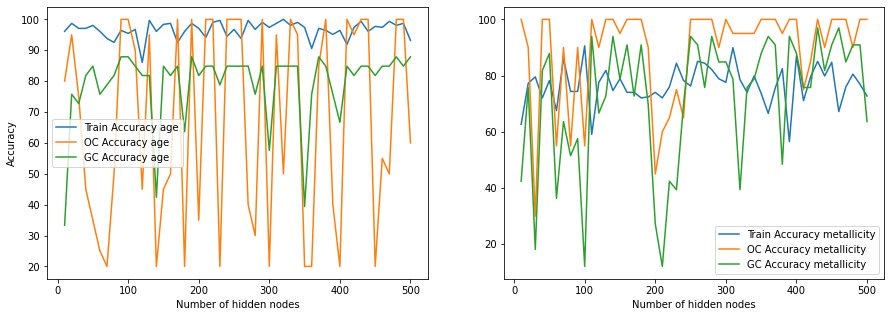

In [7]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(nr_hidden, acc_age_train, label = "Train Accuracy age")
axs[0].plot(nr_hidden, acc_age_oc, label = "OC Accuracy age")
axs[0].plot(nr_hidden, acc_age_gc, label = "GC Accuracy age")

axs[1].plot(nr_hidden, acc_z_train, label = "Train Accuracy metallicity")
axs[1].plot(nr_hidden, acc_z_oc, label = "OC Accuracy metallicity")
axs[1].plot(nr_hidden, acc_z_gc, label = "GC Accuracy metallicity")

axs[0].set_xlabel('Number of hidden nodes')
axs[1].set_xlabel('Number of hidden nodes')
axs[0].set_ylabel('Accuracy')

axs[0].legend()
axs[1].legend()
plt.savefig("Graphs/relu_acc.png")
plt.show()

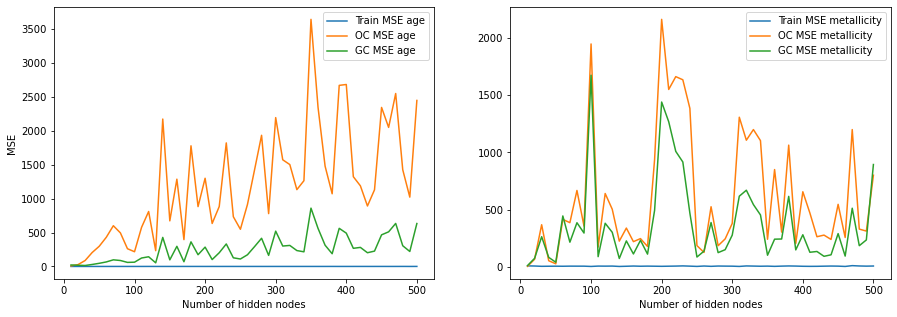

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(nr_hidden, mse_age_train, label = "Train MSE age")
axs[0].plot(nr_hidden, mse_age_oc, label = "OC MSE age")
axs[0].plot(nr_hidden, mse_age_gc, label = "GC MSE age")

axs[1].plot(nr_hidden, mse_z_train, label = "Train MSE metallicity")
axs[1].plot(nr_hidden, mse_z_oc, label = "OC MSE metallicity")
axs[1].plot(nr_hidden, mse_z_gc, label = "GC MSE metallicity")

axs[0].set_xlabel('Number of hidden nodes')
axs[1].set_xlabel('Number of hidden nodes')
axs[0].set_ylabel('MSE')

axs[0].legend()
axs[1].legend()
plt.savefig("Graphs/relu_mse.png")
plt.show()

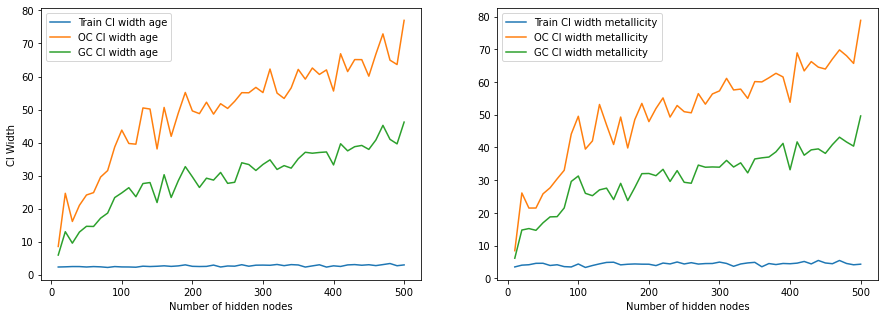

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(nr_hidden, ci_age_train, label = "Train CI width age")
axs[0].plot(nr_hidden, ci_age_oc, label = "OC CI width age")
axs[0].plot(nr_hidden, ci_age_gc, label = "GC CI width age")

axs[1].plot(nr_hidden, ci_z_train, label = "Train CI width metallicity")
axs[1].plot(nr_hidden, ci_z_oc, label = "OC CI width metallicity")
axs[1].plot(nr_hidden, ci_z_gc, label = "GC CI width metallicity")

axs[0].set_xlabel('Number of hidden nodes')
axs[1].set_xlabel('Number of hidden nodes')
axs[0].set_ylabel('CI Width')

axs[0].legend()
axs[1].legend()
plt.savefig("Graphs/relu_ci.png")
plt.show()